In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image, ExifTags, UnidentifiedImageError
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
root_folder = "./cropped_images"

labels = []
file_paths = []
i = 0
# Traverse through the root folder
for tree_folder in os.listdir(root_folder):
    tree_path = os.path.join(root_folder, tree_folder)

    # Check if it's a directory
    if os.path.isdir(tree_path):
        for file in os.listdir(tree_path):
            file_path = os.path.join(tree_path, file)
            
            # Check if the file is an image and can be opened
            try:
                with Image.open(file_path) as img:
                    # If the image can be opened, add it to the lists
                    labels.append(tree_folder)
                    file_paths.append(file_path)
            except (IOError, UnidentifiedImageError):
                # If the image cannot be opened, remove the file
                print(f"Removing damaged file: {file_path}")
                os.remove(file_path)
    i += 1
# Create a DataFrame
df = pd.DataFrame({"label": labels, "path": file_paths})

# Display the DataFrame
print(df)

                  label                                               path
0      Abies_holophylla  ./cropped_images\Abies_holophylla\102843_Abies...
1      Abies_holophylla  ./cropped_images\Abies_holophylla\102845_Abies...
2      Abies_holophylla  ./cropped_images\Abies_holophylla\102847_Abies...
3      Abies_holophylla  ./cropped_images\Abies_holophylla\102849_Abies...
4      Abies_holophylla  ./cropped_images\Abies_holophylla\102851_Abies...
...                 ...                                                ...
15257   Ziziphus_jujuba  ./cropped_images\Ziziphus_jujuba\107943_Ziziph...
15258   Ziziphus_jujuba  ./cropped_images\Ziziphus_jujuba\107945_Ziziph...
15259   Ziziphus_jujuba  ./cropped_images\Ziziphus_jujuba\107947_Ziziph...
15260   Ziziphus_jujuba  ./cropped_images\Ziziphus_jujuba\107949_Ziziph...
15261   Ziziphus_jujuba  ./cropped_images\Ziziphus_jujuba\107951_Ziziph...

[15262 rows x 2 columns]


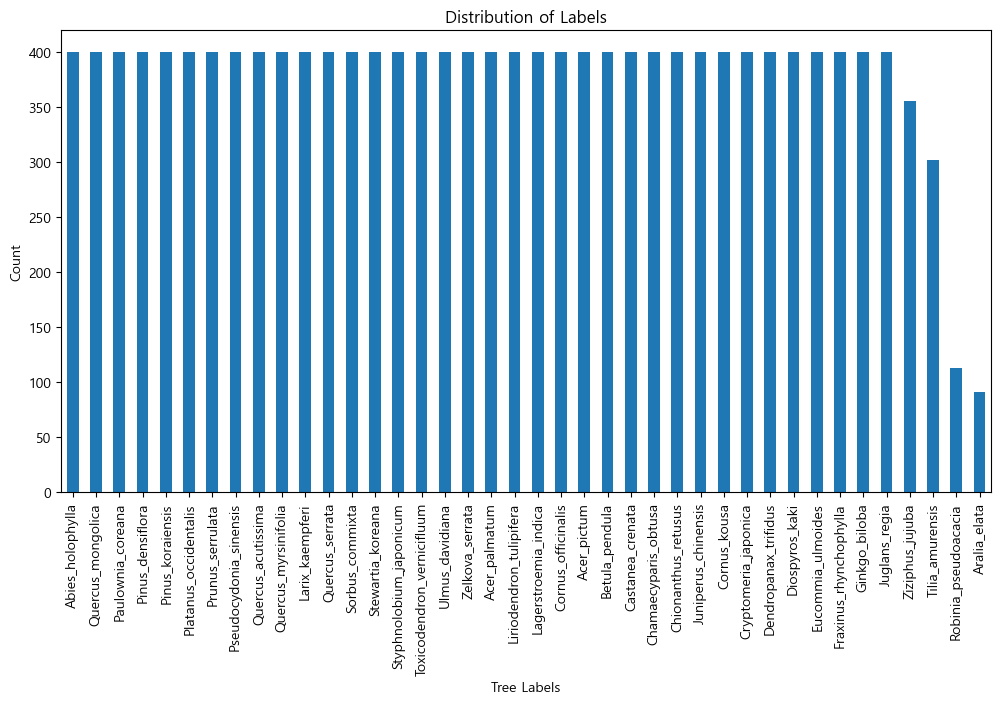

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# Assuming your DataFrame is named df

# Count the occurrences of each label
label_counts = df['label'].value_counts()
# Plot the distribution
plt.rc('font', family='Malgun Gothic')
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Tree Labels')
plt.ylabel('Count')
plt.show()

In [66]:
print(df['label'].unique())
print(len(df['label'].unique()))

['Abies_holophylla' 'Acer_palmatum' 'Acer_pictum' 'Aralia_elata'
 'Betula_pendula' 'Castanea_crenata' 'Chamaecyparis_obtusa'
 'Chionanthus_retusus' 'Cornus_kousa' 'Cornus_officinalis'
 'Cryptomeria_japonica' 'Dendropanax_trifidus' 'Diospyros_kaki'
 'Eucommia_ulmoides' 'Fraxinus_rhynchophylla' 'Ginkgo_biloba'
 'Juglans_regia' 'Juniperus_chinensis' 'Lagerstroemia_indica'
 'Larix_kaempferi' 'Liriodendron_tulipifera' 'Paulownia_coreana'
 'Pinus_densiflora' 'Pinus_koraiensis' 'Platanus_occidentalis'
 'Prunus_serrulata' 'Pseudocydonia_sinensis' 'Quercus_acutissima'
 'Quercus_mongolica' 'Quercus_myrsinifolia' 'Quercus_serrata'
 'Robinia_pseudoacacia' 'Sorbus_commixta' 'Stewartia_koreana'
 'Styphnolobium_japonicum' 'Tilia_amurensis' 'Toxicodendron_vernicifluum'
 'Ulmus_davidiana' 'Zelkova_serrata' 'Ziziphus_jujuba']
40


In [6]:
# EXIF 데이터를 통해 이미지 방향을 수정하는 함수
def correct_image_orientation(img):
    try:
        exif = img._getexif()
        if exif is not None:
            for orientation_tag, orientation_value in ExifTags.TAGS.items():
                if orientation_value == 'Orientation':
                    orientation = exif.get(orientation_tag)
                    if orientation == 3:
                        img = img.rotate(180, expand=True)
                    elif orientation == 6:
                        img = img.rotate(270, expand=True)
                    elif orientation == 8:
                        img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError, TypeError):
        # EXIF 데이터가 없거나, 태그를 찾을 수 없거나, 이미지 포맷이 EXIF를 지원하지 않는 경우
        pass
    return img

In [60]:
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

In [61]:
decoded_predictions = label_encoder.inverse_transform(df['label_encoded'])

In [63]:
decoded_predictions[0:15]

array(['Abies_holophylla', 'Abies_holophylla', 'Abies_holophylla',
       'Abies_holophylla', 'Abies_holophylla', 'Abies_holophylla',
       'Abies_holophylla', 'Abies_holophylla', 'Abies_holophylla',
       'Abies_holophylla', 'Abies_holophylla', 'Abies_holophylla',
       'Abies_holophylla', 'Abies_holophylla', 'Abies_holophylla'],
      dtype=object)

In [64]:
df

,label,path,label_encoded
0,Abies_holophylla,./cropped_images\Abies_holophylla\102843_Abies...,0
1,Abies_holophylla,./cropped_images\Abies_holophylla\102845_Abies...,0
2,Abies_holophylla,./cropped_images\Abies_holophylla\102847_Abies...,0
3,Abies_holophylla,./cropped_images\Abies_holophylla\102849_Abies...,0
4,Abies_holophylla,./cropped_images\Abies_holophylla\102851_Abies...,0
...,...,...,...
15257,Ziziphus_jujuba,./cropped_images\Ziziphus_jujuba\107943_Ziziph...,39
15258,Ziziphus_jujuba,./cropped_images\Ziziphus_jujuba\107945_Ziziph...,39
15259,Ziziphus_jujuba,./cropped_images\Ziziphus_jujuba\107947_Ziziph...,39
15260,Ziziphus_jujuba,./cropped_images\Ziziphus_jujuba\107949_Ziziph...,39


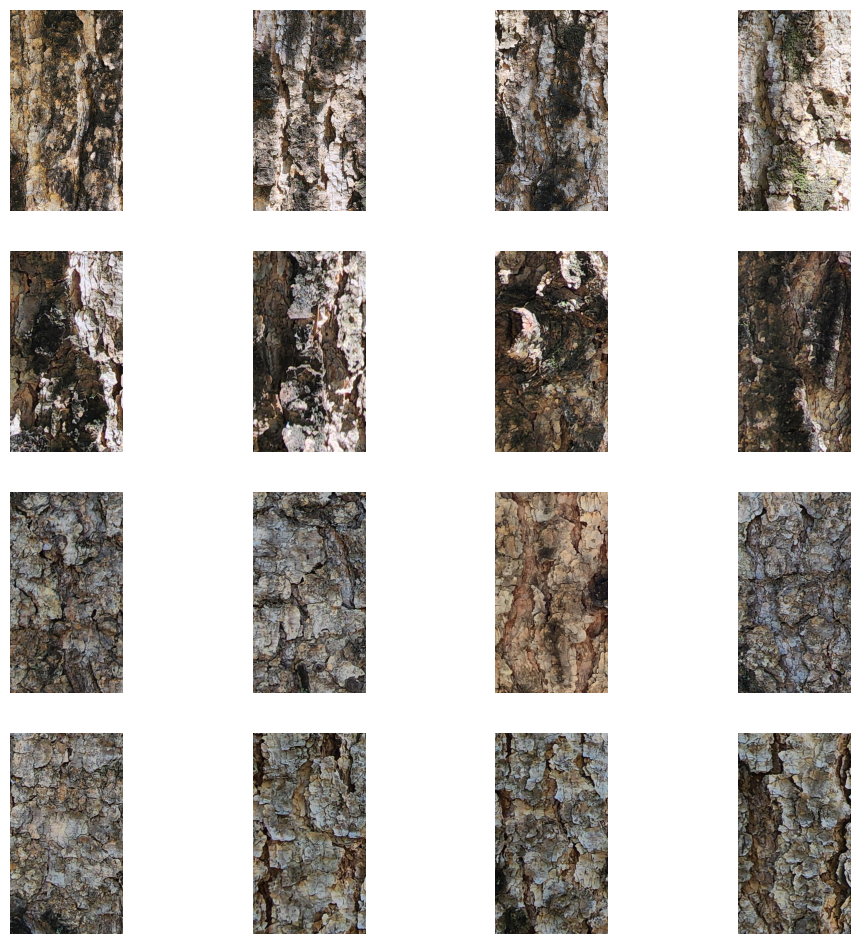

In [10]:
# 이미지 파일 경로들
image_paths = df['path'][:16]

# 이미지를 4x4 격자로 출력
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flatten()):
    # 이미지 불러오기
    img_path = image_paths[i]
    img = Image.open(img_path)

    # 이미지 출력
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [11]:
train_ratio = 0.7
test_ratio = 0.15
valid_ratio = 0.15

train, test_valid = train_test_split(df, test_size=(test_ratio + valid_ratio), random_state=42, stratify=df['label_encoded'])
test, valid = train_test_split(test_valid, test_size=valid_ratio/(test_ratio + valid_ratio), random_state=42, stratify=test_valid['label_encoded'])

train = train.drop(columns=['label'])
test = test.drop(columns=['label'])
valid = valid.drop(columns=['label'])

In [12]:
train

,path,label_encoded
12693,./cropped_images\Stewartia_koreana\39763_Stewa...,33
2388,./cropped_images\Chamaecyparis_obtusa\15068_Ch...,6
4350,./cropped_images\Dendropanax_trifidus\50555_De...,11
10198,./cropped_images\Pseudocydonia_sinensis\95703_...,26
2828,./cropped_images\Chionanthus_retusus\65867_Chi...,7
...,...,...
1318,./cropped_images\Betula_pendula\17019_Betula_p...,4
9386,./cropped_images\Platanus_occidentalis\29187_P...,24
6440,./cropped_images\Juglans_regia\93365_Juglans_r...,16
5647,./cropped_images\Fraxinus_rhynchophylla\85121_...,14


In [38]:
BATCH_SIZE = 16

class TreeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        out = dict()
        img_path = self.dataframe['path'].iloc[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        image = image.clone().detach().requires_grad_(True).to(torch.float)
        label = torch.tensor(self.dataframe['label_encoded'].iloc[idx], dtype=torch.long)
        
        return image, label


transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=target_mean, std=target_std),
])

In [19]:
pyramid_folder = './pyramid'
os.makedirs(pyramid_folder, exist_ok=True)  # 폴더가 없으면 생성

In [22]:
def create_image_pyramid(img_path, pyramid_folder, levels=4):
    img = Image.open(img_path)
    pyramid = [img_path]  # 원본 이미지 포함

    for level in range(1, levels):
        img_resized = img.resize((img.width // 2**level, img.height // 2**level), Image.ANTIALIAS)
        
        # 원본 파일명과 확장자 분리
        base_name = os.path.basename(img_path)
        name, ext = os.path.splitext(base_name)
        
        # 새 파일명 생성
        resized_path = os.path.join(pyramid_folder, f"{name}_pyramid_{level}{ext}")
        img_resized.save(resized_path)
        pyramid.append(resized_path)

    return pyramid


In [23]:
extended_data = []
for _, row in df.iterrows():
    pyramid_paths = create_image_pyramid(row['path'], pyramid_folder)
    for path in pyramid_paths:
        extended_data.append({'path': path, 'label_encoded': row['label_encoded']})

extended_df = pd.DataFrame(extended_data)


C:\Users\com\AppData\Local\Temp\ipykernel_12584\2147481214.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img_resized = img.resize((img.width // 2**level, img.height // 2**level), Image.ANTIALIAS)


In [26]:
train = extended_df
train

,path,label_encoded
0,./cropped_images\Abies_holophylla\102843_Abies...,0
1,./pyramid\102843_Abies_holophylla_pyramid_1.jpg,0
2,./pyramid\102843_Abies_holophylla_pyramid_2.jpg,0
3,./pyramid\102843_Abies_holophylla_pyramid_3.jpg,0
4,./cropped_images\Abies_holophylla\102845_Abies...,0
...,...,...
61043,./pyramid\107949_Ziziphus_jujuba_pyramid_3.jpg,39
61044,./cropped_images\Ziziphus_jujuba\107951_Ziziph...,39
61045,./pyramid\107951_Ziziphus_jujuba_pyramid_1.jpg,39
61046,./pyramid\107951_Ziziphus_jujuba_pyramid_2.jpg,39


In [34]:
# 원하는 원본 이미지 파일명
original_image_name = '102843_Abies_holophylla'

# 해당 원본 이미지의 피라미드 이미지들을 필터링
pyramid_images = train[train['path'].str.contains(original_image_name)]

# 결과 출력
pyramid_images

,path,label_encoded
0,./cropped_images\Abies_holophylla\102843_Abies...,0
1,./pyramid\102843_Abies_holophylla_pyramid_1.jpg,0
2,./pyramid\102843_Abies_holophylla_pyramid_2.jpg,0
3,./pyramid\102843_Abies_holophylla_pyramid_3.jpg,0


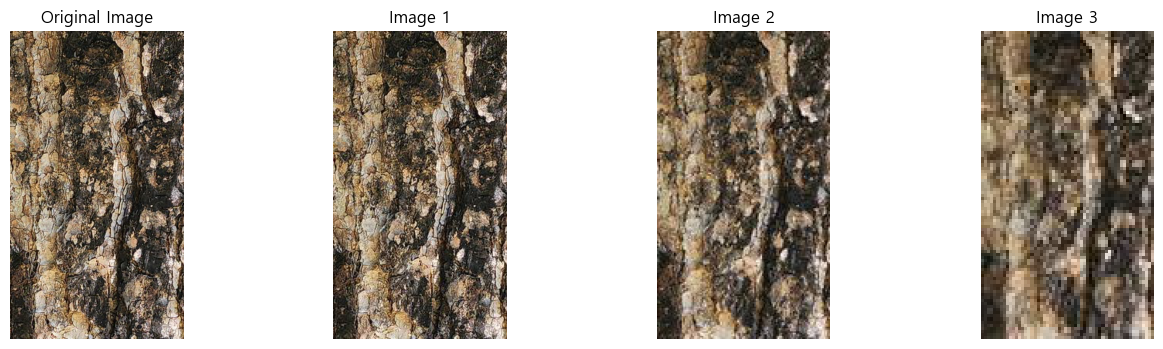

In [37]:
plt.figure(figsize=(16, 4))

for i, img_path in enumerate(pyramid_images['path'], 1):
    img = Image.open(img_path)
    plt.subplot(1, 4, i)
    plt.imshow(img)
    if i == 1:
        plt.title(f"Original Image")
    else:
        plt.title(f"Image {i-1}")
    plt.axis('off')

plt.show()

In [39]:
train_dataset = TreeDataset(dataframe=train, transform=transform)
test_dataset = TreeDataset(dataframe=test, transform=transform)
valid_dataset = TreeDataset(dataframe=valid, transform=transform)
print(len(train_dataset))
print(len(test_dataset))
print(len(valid_dataset))

61048
2289
2290


In [40]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

3816
144
144


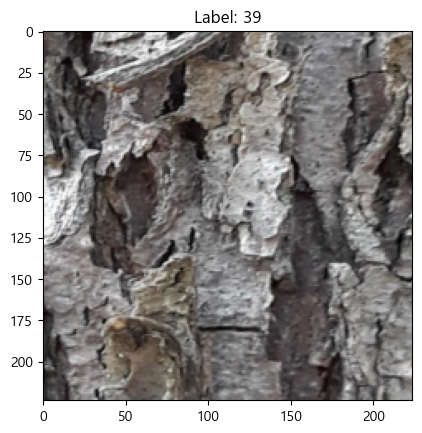

In [16]:
for images, labels in train_loader:
    
    # 이미지를 시각화하기 위해 배치에서 이미지 하나를 선택
    img = images[0].detach().cpu().permute(1, 2, 0).numpy()  # 채널 순서 변경 및 NumPy 배열로 변환
    # print(img)
    # print(img.shape)
    
    # 이미지 시각화
    plt.imshow(img)
    plt.title(f"Label: {labels[0]}")
    plt.show()
    
    break  # 첫 번째 배치만 시각화

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
model = models.resnet50(pretrained=True).to(device)
num_classes = len(df['label_encoded'].unique())

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(inplace = True),
    nn.Linear(128, num_classes)).to(device)



In [44]:
# 손실 함수와 최적화 알고리즘 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
num_epochs = 30
best_val_accuracy = 0.0  # 최고의 검증 정확도를 저장하기 위한 변수

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', position=0, leave=True):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Training Loss: {average_loss}')

    # Validation
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        accuracy = total_correct / total_samples
        average_val_loss = total_val_loss / len(valid_loader)
        print(f'Validation Loss: {average_val_loss}, Validation Accuracy: {accuracy * 100:.2f}%')

        # 최고의 검증 정확도일 때 모델 저장
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), 'best_tree_cropped_classifier.pth')
            print('Best model saved.')

# 전체 학습이 끝난 후 최고의 모델을 저장했습니다.



Epoch 1/30: 100%|██████████| 3816/3816 [08:55<00:00,  7.13it/s]


Training Loss: 1.6762808717365534
Validation Loss: 0.9345174953341484, Validation Accuracy: 72.49%
Best model saved.


Epoch 2/30: 100%|██████████| 3816/3816 [09:12<00:00,  6.90it/s]


Training Loss: 1.2494071827736728
Validation Loss: 0.8068055330465237, Validation Accuracy: 75.76%
Best model saved.


Epoch 3/30: 100%|██████████| 3816/3816 [09:03<00:00,  7.02it/s]


Training Loss: 1.1603282978621543
Validation Loss: 0.662513721630805, Validation Accuracy: 80.17%
Best model saved.


Epoch 4/30: 100%|██████████| 3816/3816 [09:07<00:00,  6.98it/s]


Training Loss: 1.1150205152800436
Validation Loss: 0.6731440140348341, Validation Accuracy: 80.26%
Best model saved.


Epoch 5/30: 100%|██████████| 3816/3816 [09:17<00:00,  6.84it/s]


Training Loss: 1.0707804450894114
Validation Loss: 0.6314670808820261, Validation Accuracy: 81.35%
Best model saved.


Epoch 6/30: 100%|██████████| 3816/3816 [09:04<00:00,  7.01it/s]


Training Loss: 1.047823911368753
Validation Loss: 0.637568564257688, Validation Accuracy: 80.79%


Epoch 7/30: 100%|██████████| 3816/3816 [09:01<00:00,  7.05it/s]


Training Loss: 1.0263195494521777
Validation Loss: 0.5710815540514886, Validation Accuracy: 82.31%
Best model saved.


Epoch 8/30: 100%|██████████| 3816/3816 [09:27<00:00,  6.72it/s]


Training Loss: 1.0069879033803877
Validation Loss: 0.46918867011037135, Validation Accuracy: 86.16%
Best model saved.


Epoch 9/30: 100%|██████████| 3816/3816 [09:07<00:00,  6.97it/s]


Training Loss: 0.9897954288881811
Validation Loss: 0.49422855980487335, Validation Accuracy: 84.89%


Epoch 10/30: 100%|██████████| 3816/3816 [08:59<00:00,  7.07it/s]


Training Loss: 0.9670266391459532
Validation Loss: 0.4871876786669923, Validation Accuracy: 84.50%


Epoch 11/30: 100%|██████████| 3816/3816 [09:16<00:00,  6.86it/s]


Training Loss: 0.9542239966042793
Validation Loss: 0.47907796684497345, Validation Accuracy: 85.85%


Epoch 12/30: 100%|██████████| 3816/3816 [09:12<00:00,  6.90it/s]


Training Loss: 0.9411566138376855
Validation Loss: 0.49137150641116834, Validation Accuracy: 85.90%


Epoch 13/30: 100%|██████████| 3816/3816 [09:21<00:00,  6.80it/s]


Training Loss: 0.9362774437490609
Validation Loss: 0.5012302860462418, Validation Accuracy: 84.89%


Epoch 14/30: 100%|██████████| 3816/3816 [09:33<00:00,  6.66it/s]


Training Loss: 0.9218591205478964
Validation Loss: 0.489858646514929, Validation Accuracy: 85.24%


Epoch 15/30: 100%|██████████| 3816/3816 [09:36<00:00,  6.62it/s]


Training Loss: 0.9079408003895912
Validation Loss: 0.4439924883061192, Validation Accuracy: 86.99%
Best model saved.


Epoch 16/30: 100%|██████████| 3816/3816 [10:08<00:00,  6.27it/s]


Training Loss: 0.908324354617179
Validation Loss: 0.4522359195786218, Validation Accuracy: 86.68%


Epoch 17/30: 100%|██████████| 3816/3816 [09:21<00:00,  6.79it/s]


Training Loss: 0.8914264914456684
Validation Loss: 0.46521103175150025, Validation Accuracy: 85.41%


Epoch 18/30: 100%|██████████| 3816/3816 [09:18<00:00,  6.83it/s]


Training Loss: 0.8823296339124191
Validation Loss: 0.4080133059889906, Validation Accuracy: 87.73%
Best model saved.


Epoch 19/30: 100%|██████████| 3816/3816 [09:46<00:00,  6.51it/s]


Training Loss: 0.8732025802283855
Validation Loss: 0.46073791270868647, Validation Accuracy: 86.16%


Epoch 20/30: 100%|██████████| 3816/3816 [09:06<00:00,  6.99it/s]


Training Loss: 0.8725626605799113
Validation Loss: 0.42640917878856677, Validation Accuracy: 88.03%
Best model saved.


Epoch 21/30: 100%|██████████| 3816/3816 [09:29<00:00,  6.70it/s]


Training Loss: 0.8625769692256391
Validation Loss: 0.3978319967734731, Validation Accuracy: 87.77%


Epoch 22/30: 100%|██████████| 3816/3816 [08:57<00:00,  7.10it/s]


Training Loss: 0.8601255667067876
Validation Loss: 0.4008847449440509, Validation Accuracy: 87.95%


Epoch 23/30: 100%|██████████| 3816/3816 [09:07<00:00,  6.97it/s]


Training Loss: 0.8448844235009695
Validation Loss: 0.35008622279080254, Validation Accuracy: 89.34%
Best model saved.


Epoch 24/30: 100%|██████████| 3816/3816 [09:00<00:00,  7.06it/s]


Training Loss: 0.8456302004606625
Validation Loss: 0.39729706971492207, Validation Accuracy: 88.30%


Epoch 25/30: 100%|██████████| 3816/3816 [09:16<00:00,  6.86it/s]


Training Loss: 0.8481120325417982
Validation Loss: 0.3855734741470466, Validation Accuracy: 88.43%


Epoch 26/30: 100%|██████████| 3816/3816 [09:16<00:00,  6.86it/s]


Training Loss: 0.8372114742549617
Validation Loss: 0.3548792305971599, Validation Accuracy: 89.78%
Best model saved.


Epoch 27/30: 100%|██████████| 3816/3816 [09:16<00:00,  6.86it/s]


Training Loss: 0.8246471056738084
Validation Loss: 0.3703590260249459, Validation Accuracy: 88.52%


Epoch 28/30: 100%|██████████| 3816/3816 [09:02<00:00,  7.04it/s]


Training Loss: 0.8213438588747095
Validation Loss: 0.3761638835745139, Validation Accuracy: 89.00%


Epoch 29/30: 100%|██████████| 3816/3816 [09:02<00:00,  7.04it/s]


Training Loss: 0.8225599238395191
Validation Loss: 0.3838518748266829, Validation Accuracy: 88.30%


Epoch 30/30: 100%|██████████| 3816/3816 [09:04<00:00,  7.01it/s]


Training Loss: 0.8170991341673244
Validation Loss: 0.38422667542989886, Validation Accuracy: 88.34%


## HUFS tree

In [71]:
hufs_df = pd.DataFrame({'path':['./cropped_images_hufs/ginkgo_1.jpg', './cropped_images_hufs/ginkgo_2.jpg', './cropped_images_hufs/ginkgo_3.jpg',
                               './cropped_images_hufs/sakura_1.jpg', './cropped_images_hufs/sakura_2.jpg', './cropped_images_hufs/sakura_3.jpg'],
                             'label_encoded':[15, 15, 15, 25, 25, 25]})

hufs_dataset = TreeDataset(dataframe = hufs_df, transform=transform)
hufs_loader = DataLoader(hufs_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [72]:
hufs_df

,path,label_encoded
0,./cropped_images_hufs/ginkgo_1.jpg,15
1,./cropped_images_hufs/ginkgo_2.jpg,15
2,./cropped_images_hufs/ginkgo_3.jpg,15
3,./cropped_images_hufs/sakura_1.jpg,25
4,./cropped_images_hufs/sakura_2.jpg,25
5,./cropped_images_hufs/sakura_3.jpg,25


In [73]:
predictions = []
with torch.no_grad():
    for images, labels in hufs_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [74]:
predictions

[15, 15, 34, 3, 7, 25]

In [76]:
for i, prediction in enumerate(predictions):
    tree_class = label_encoder.inverse_transform([prediction])
    print(f"Tree {i + 1}: Predicted Class - {tree_class}, True Class - {label_encoder.inverse_transform([hufs_df.label_encoded[i]])}")
    plt.show()

Tree 1: Predicted Class - ['Ginkgo_biloba'], True Class - ['Ginkgo_biloba']
Tree 2: Predicted Class - ['Ginkgo_biloba'], True Class - ['Ginkgo_biloba']
Tree 3: Predicted Class - ['Styphnolobium_japonicum'], True Class - ['Ginkgo_biloba']
Tree 4: Predicted Class - ['Aralia_elata'], True Class - ['Prunus_serrulata']
Tree 5: Predicted Class - ['Chionanthus_retusus'], True Class - ['Prunus_serrulata']
Tree 6: Predicted Class - ['Prunus_serrulata'], True Class - ['Prunus_serrulata']
